In [0]:
!wget https://download.pytorch.org/tutorial/data.zip

--2019-07-28 04:52:14--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.253.114, 13.224.253.46, 13.224.253.59, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.253.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.1s    

2019-07-28 04:52:14 (28.0 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [0]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import math
import random

In [0]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1  # Plus EOS marker


def findFiles(path): return glob.glob(path)


# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


# Build the category_lines dictionary, a list of lines per category
category_lines = {}
train_data = {}
test_data = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.8 * len(lines)))]
    test_data[category] = lines[int(math.floor(0.8 * len(lines))) + 1:]
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
                       'from https://download.pytorch.org/tutorial/data.zip and extract it to '
                       'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'NÃ©Ã l"))

# categories: 18 ['Spanish', 'Japanese', 'Chinese', 'Czech', 'Portuguese', 'Scottish', 'English', 'Italian', 'Irish', 'Korean', 'German', 'Greek', 'French', 'Arabic', 'Russian', 'Polish', 'Vietnamese', 'Dutch']
O'NAA l


In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model = 'i'):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.model = model
        
        if self.model == 'ii':
          self.i2h_0 = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
          self.i2o_0 = nn.Linear(n_categories + input_size + hidden_size, output_size)
          self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
          self.i2o = nn.Linear(input_size + hidden_size, output_size)
          
        elif self.model == 'iii':
          self.i2h = nn.Linear(n_categories + hidden_size, hidden_size)
          self.i2o = nn.Linear(n_categories + hidden_size, output_size)
          
        elif self.model == 'iv':
          self.i2h_0 = nn.Linear(n_categories + hidden_size, hidden_size)
          self.i2o_0 = nn.Linear(n_categories + hidden_size, output_size)
          self.i2h = nn.Linear(hidden_size, hidden_size)
          self.i2o = nn.Linear(hidden_size, output_size) 
          
        else:
          self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
          self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)    
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden, time_step):
#       print(time_step)
      if self.model == 'ii':
          if time_step == 0:
            input_combined = torch.cat((category, input, hidden), 1)  
#             print(input_combined.shape, hidden.shape, input.shape, category.shape)
            hidden = self.i2h_0(input_combined)
#             print(hidden.shape)
            output = self.i2o_0(input_combined)
          else:
            input_combined = torch.cat((input, hidden), 1) 
            hidden = self.i2h(input_combined)
            output = self.i2o(input_combined)              
        
      elif self.model == 'iii':
        input_combined = torch.cat((category, hidden), 1)  
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)

      elif self.model == 'iv':
        if time_step == 0:
          input_combined = torch.cat((category, hidden), 1)
          hidden = self.i2h_0(input_combined)
          output = self.i2o_0(input_combined)
        else: 
          hidden = self.i2h(hidden)
          output = self.i2o(hidden)

      else:  
        input_combined = torch.cat((category, input, hidden), 1)   
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)

      output_combined = torch.cat((hidden, output), 1)
#       print(output_combined.shape)
      output = self.o2o(output_combined)
      output = self.dropout(output)
      output = self.softmax(output)
      return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
import random


# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]


# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    return category, line

In [0]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor


# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor


# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)  # EOS
    return torch.LongTensor(letter_indexes)


# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [0]:
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden, i)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

In [0]:
import time
import math


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


# Just return an output given a line
def evaluate(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden, i)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

In [0]:
# n_letters

In [0]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

n_iters = 100000
print_every = 5000
plot_every = 1000
all_losses = []
all_test_losses = []
total_loss = 0  # Reset every plot_every iters

rnn = RNN(n_letters, 128, n_letters, model = 'i')

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

    # Compute loss based on test data
    if iter % plot_every == 0:
        total_test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(categoryTensor(category))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                input_line_tensor = Variable(inputTensor(line))
                target_line_tensor = Variable(targetTensor(line))
                output, test_loss = evaluate(category_tensor, input_line_tensor, target_line_tensor)
                total_test_loss += test_loss
        all_test_losses.append(total_test_loss / n_test_instances)


0m 30s (5000 5%) 2.6977
1m 5s (10000 10%) 2.6853
1m 39s (15000 15%) 3.0085
2m 14s (20000 20%) 2.8737
2m 49s (25000 25%) 1.5873
3m 26s (30000 30%) 1.9545
4m 0s (35000 35%) 1.0807
4m 35s (40000 40%) 2.6141
5m 9s (45000 45%) 2.5919
5m 44s (50000 50%) 2.2668
6m 19s (55000 55%) 2.1295
6m 53s (60000 60%) 2.8306
7m 28s (65000 65%) 3.7093
8m 3s (70000 70%) 1.9835
8m 38s (75000 75%) 2.3006
9m 12s (80000 80%) 2.4155
9m 47s (85000 85%) 2.1788
10m 22s (90000 90%) 1.9486
10m 56s (95000 95%) 2.2837
11m 31s (100000 100%) 2.3753


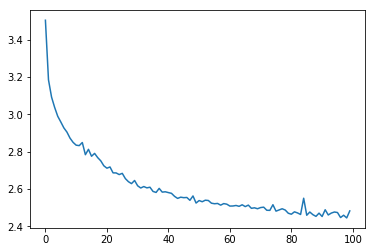

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_test_losses)

In [0]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

n_iters = 100000
print_every = 5000
plot_every = 1000
all_ii_losses = []
all_ii_test_losses = []
total_ii_loss = 0  # Reset every plot_every iters

rnn = RNN(n_letters, 128, n_letters, model = 'ii')

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_ii_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_ii_losses.append(total_ii_loss / plot_every)
        total_ii_loss = 0

    # Compute loss based on test data
    if iter % plot_every == 0:
        total_test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(categoryTensor(category))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                input_line_tensor = Variable(inputTensor(line))
                target_line_tensor = Variable(targetTensor(line))
                output, test_loss = evaluate(category_tensor, input_line_tensor, target_line_tensor)
                total_test_loss += test_loss
        all_ii_test_losses.append(total_test_loss / n_test_instances)


0m 30s (5000 5%) 3.1607
1m 5s (10000 10%) 3.0177
1m 40s (15000 15%) 2.3961
2m 15s (20000 20%) 2.8960
2m 50s (25000 25%) 3.0856
3m 25s (30000 30%) 2.9540
4m 0s (35000 35%) 2.3215
4m 35s (40000 40%) 3.3991
5m 10s (45000 45%) 2.9580
5m 44s (50000 50%) 2.6410
6m 19s (55000 55%) 2.8246
7m 1s (60000 60%) 1.9611
7m 42s (65000 65%) 2.4910
8m 24s (70000 70%) 1.6640
9m 5s (75000 75%) 2.2990
9m 47s (80000 80%) 2.3277
10m 28s (85000 85%) 2.6544
11m 10s (90000 90%) 2.5313
11m 51s (95000 95%) 2.8007
12m 33s (100000 100%) 3.2826


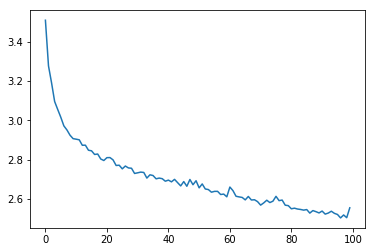

In [0]:
plt.figure()
plt.plot(all_ii_test_losses)

In [0]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

n_iters = 100000
print_every = 5000
plot_every = 1000
all_iii_losses = []
all_iii_test_losses = []
total_iii_loss = 0  # Reset every plot_every iters

rnn = RNN(n_letters, 128, n_letters, model = 'iii')

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_iii_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_iii_losses.append(total_iii_loss / plot_every)
        total_iii_loss = 0

    # Compute loss based on test data
    if iter % plot_every == 0:
        total_test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(categoryTensor(category))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                input_line_tensor = Variable(inputTensor(line))
                target_line_tensor = Variable(targetTensor(line))
                output, test_loss = evaluate(category_tensor, input_line_tensor, target_line_tensor)
                total_test_loss += test_loss
        all_iii_test_losses.append(total_test_loss / n_test_instances)


0m 29s (5000 5%) 3.2777
1m 3s (10000 10%) 2.6023
1m 37s (15000 15%) 2.8694
2m 11s (20000 20%) 2.7161
2m 45s (25000 25%) 2.4837
3m 19s (30000 30%) 2.2297
3m 53s (35000 35%) 2.2747
4m 27s (40000 40%) 2.1102
5m 1s (45000 45%) 2.1946
5m 35s (50000 50%) 2.6417
6m 9s (55000 55%) 2.6153
6m 43s (60000 60%) 2.2182
7m 17s (65000 65%) 3.1524
7m 50s (70000 70%) 3.1695
8m 24s (75000 75%) 3.3533
8m 58s (80000 80%) 1.8057
9m 32s (85000 85%) 2.0535
10m 6s (90000 90%) 3.3868
10m 40s (95000 95%) 1.5913
11m 14s (100000 100%) 2.8282


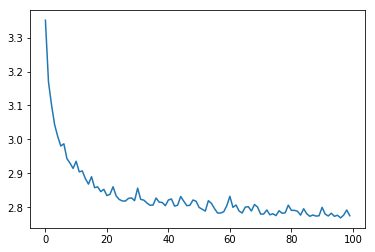

In [0]:
plt.figure()
plt.plot(all_iii_test_losses)

In [0]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

n_iters = 100000
print_every = 5000
plot_every = 1000
all_iv_losses = []
all_iv_test_losses = []
total_iv_loss = 0  # Reset every plot_every iters

rnn = RNN(n_letters, 128, n_letters, model = 'iv')

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_iv_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_iv_losses.append(total_iv_loss / plot_every)
        total_iv_loss = 0

    # Compute loss based on test data
    if iter % plot_every == 0:
        total_test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(categoryTensor(category))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                input_line_tensor = Variable(inputTensor(line))
                target_line_tensor = Variable(targetTensor(line))
                output, test_loss = evaluate(category_tensor, input_line_tensor, target_line_tensor)
                total_test_loss += test_loss
        all_iv_test_losses.append(total_test_loss / n_test_instances)


0m 28s (5000 5%) 3.1543
1m 1s (10000 10%) 2.3746
1m 34s (15000 15%) 3.1440
2m 7s (20000 20%) 3.4446
2m 40s (25000 25%) 2.5206
3m 13s (30000 30%) 2.8696
3m 46s (35000 35%) 3.2555
4m 19s (40000 40%) 2.8708
4m 52s (45000 45%) 2.6958
5m 25s (50000 50%) 2.6104
5m 58s (55000 55%) 2.2510
6m 30s (60000 60%) 3.6989
7m 3s (65000 65%) 2.6142
7m 36s (70000 70%) 1.6238
8m 9s (75000 75%) 3.4367
8m 42s (80000 80%) 2.0834
9m 15s (85000 85%) 2.6988
9m 48s (90000 90%) 3.1654
10m 22s (95000 95%) 2.7276
10m 55s (100000 100%) 2.9576


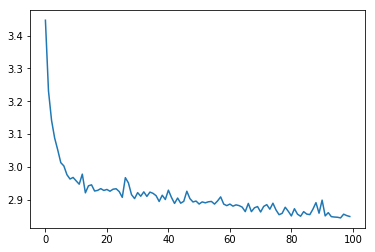

In [0]:
plt.figure()
plt.plot(all_iv_test_losses)

<Figure size 432x288 with 0 Axes>

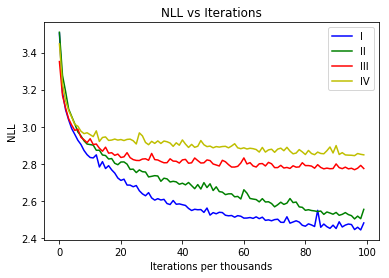

<Figure size 432x288 with 0 Axes>

In [19]:
plt.plot(all_test_losses,'b',label='I')
plt.plot(all_ii_test_losses,'g',label='II')
plt.plot(all_iii_test_losses,'r',label='III')
plt.plot(all_iv_test_losses,'y',label='IV')

plt.title('NLL vs Iterations')
plt.xlabel("Iterations per thousands")
plt.ylabel("NLL")
plt.legend()
plt.savefig("Feeding_inputs_graph.png")
plt.figure()
